In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from utils import SolverUtils
class RungeKutta4(object):
    def __init__(self, df_system, h):
        self.df_system = df_system
        self.h = h
        self.n_eqs = len(self.df_system)

    # O is the array of functions evaluated at a point
    def __call__(self, t_prev, O_prev):
        K1 = np.array([func(t_prev, *O_prev) for func in self.df_system]) * self.h
        
        next_O_prev = O_prev + K1/2
        next_t_prev = t_prev + self.h / 2
        K2 = np.array([func(next_t_prev, *next_O_prev) for func in self.df_system]) * self.h


        next_O_prev = O_prev + K2/2
        next_t_prev = t_prev + self.h / 2
        K3 = np.array([func(next_t_prev, *next_O_prev) for func in self.df_system]) * self.h

        next_O_prev = O_prev + K3
        next_t_prev = t_prev + self.h
        K4 = np.array([func(next_t_prev, *next_O_prev) for func in self.df_system]) * self.h

        # Compute the current output vector
        O = O_prev + (K1 + 2*K2 + 2*K3 + K4) / 6
        O = np.clip(O, 0.0, 1.0)
        return O


In [3]:
import matplotlib.pyplot as plt
import numpy as np
class SolverUtils(object):
    @staticmethod
    def plot_solution(timesteps, solution_timesteps):
        plt.figure()
        n_eqs = len(solution_timesteps[0])
        for eq in range(n_eqs):
            eq_solution_timesteps = [sol[eq] for sol in solution_timesteps]
            plt.plot(timesteps, eq_solution_timesteps)
        plt.show()

    @staticmethod
    def solve_system(solver, initial_conditions, n_steps):
        solution_timesteps = [initial_conditions]
        t = 0
        h = solver.h
        timesteps = [t]

        for _ in range(n_steps):
            O = solver(t, initial_conditions)
            t += h
            initial_conditions = O
            solution_timesteps.append(O)
            timesteps.append(t)
        return timesteps, solution_timesteps
    
    @staticmethod
    def calculate_error(timesteps, solution_timesteps, f_system):
        total_error = 0
        errors = []

        for (t, approx_sol) in list(zip(timesteps, solution_timesteps)):
            real_sol = np.array([f(t) for f in f_system])
            approx_sol = np.array(approx_sol)

            err = np.linalg.norm(real_sol - approx_sol)
            total_error += err
            errors.append(err)
        return total_error / len(timesteps), errors 


In [4]:
SUSCEPTIBLE_TO_SYMPTOMATIC = 3.0
SUSCEPTIBLE_TO_ASYMTOMATIC = 3.0
ASYMPTOMATIC_TO_SYMPTOMATIC = 3.0
SYMPTOMATIC_TO_RECOVERED = 2.0

In [5]:
# Some become symptomatic, some become asymptomatic +
def S_prime(t, S, Ias, Is, R):
    return -SUSCEPTIBLE_TO_SYMPTOMATIC * S * Is - SUSCEPTIBLE_TO_ASYMTOMATIC * S * Ias

# Some susceptibles become symptomatic, some asymptomatic become symptomatic +
# Some symptomatic become recovered -
def Is_prime(t, S, Ias, Is, R):
    return SUSCEPTIBLE_TO_SYMPTOMATIC * S * Is + ASYMPTOMATIC_TO_SYMPTOMATIC * Ias * Is - SYMPTOMATIC_TO_RECOVERED * Is

# Some susceptibles become asymptomatic +
# Some asymptomatic become symptomatic -
def Ias_prime(t, S, Ias, Is, R):
    return SUSCEPTIBLE_TO_SYMPTOMATIC * S * Ias - ASYMPTOMATIC_TO_SYMPTOMATIC * Ias * Is

# Symptomatic become recovered +
def R_prime(t, S, Ias, Is, R):
    return SYMPTOMATIC_TO_RECOVERED * Is

# TO CHECK IF Is_prime and Ias_prime terms with ASYMASYMPTOMATIC_TO_SYMPTOMATIC require multiplication by S

In [6]:
N = 1 # whole population
Ias_init = 0.01 # asymptomatic 
Is_init = 0.01 # symptomatic
S_init = N - Is_init - Ias_init # susceptibles
R_init = 0 # recovered
INITIAL_CONDITIONS = [S_init, Ias_init, Is_init, R_init]
h = 0.01
N_STEPS = 4000

In [7]:
solver = RungeKutta4([S_prime, Ias_prime, Is_prime, R_prime], h)
timesteps, solution_timesteps = SolverUtils.solve_system(solver, INITIAL_CONDITIONS, N_STEPS)

<IPython.core.display.Javascript object>


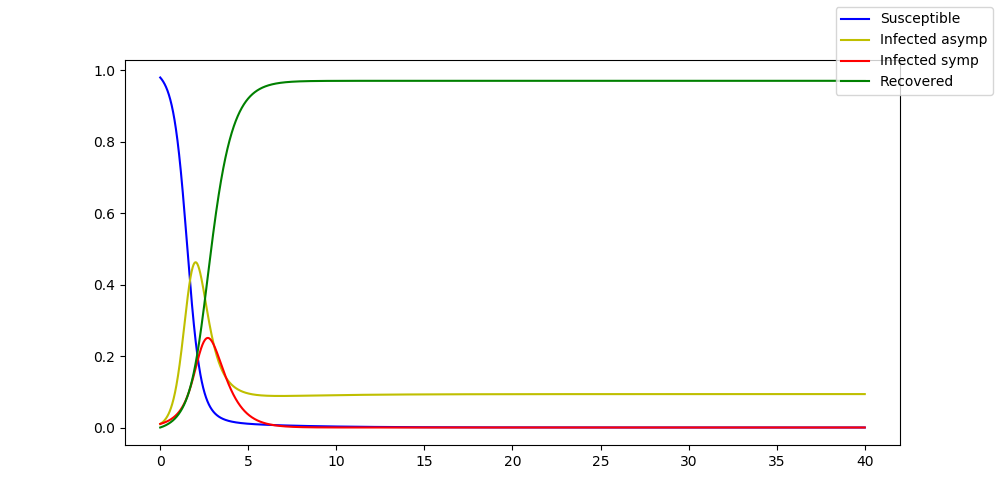

interactive(children=(FloatSlider(value=2.75, description='as_to_s', max=5.0, min=0.5), Output()), _dom_classe…

interactive(children=(FloatSlider(value=2.75, description='sus_to_s', max=5.0, min=0.5), Output()), _dom_class…

interactive(children=(FloatSlider(value=2.75, description='sus_to_as', max=5.0, min=0.5), Output()), _dom_clas…

interactive(children=(FloatSlider(value=2.75, description='s_to_rec', max=5.0, min=0.5), Output()), _dom_class…

In [8]:
from ipywidgets import *

COLORS = ['b', 'y', 'r', 'g']
LABELS = ['Susceptible', 'Infected asymp', 'Infected symp', 'Recovered']
plt.rcParams["figure.figsize"] = [10,5]

S_timesteps = [sol[0] for sol in solution_timesteps]
Ias_timesteps = [sol[1] for sol in solution_timesteps]
Is_timesteps = [sol[2] for sol in solution_timesteps]
R_timesteps = [sol[3] for sol in solution_timesteps]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
S_trace = ax.plot(timesteps, S_timesteps, color=COLORS[0], label=LABELS[0])[0]
Ias_trace = ax.plot(timesteps, Ias_timesteps, color=COLORS[1], label=LABELS[1])[0]
Is_trace = ax.plot(timesteps, Is_timesteps, color=COLORS[2], label=LABELS[2])[0]
R_trace = ax.plot(timesteps, R_timesteps, color=COLORS[3], label=LABELS[3])[0]
fig.legend()
def update_sus_to_as(sus_to_as):
    global SUSCEPTIBLE_TO_ASYMTOMATIC
    SUSCEPTIBLE_TO_ASYMTOMATIC = sus_to_as
    timesteps, solution_timesteps = SolverUtils.solve_system(solver, INITIAL_CONDITIONS, N_STEPS)
    S_timesteps = [sol[0] for sol in solution_timesteps]
    Ias_timesteps = [sol[1] for sol in solution_timesteps]
    Is_timesteps = [sol[2] for sol in solution_timesteps]
    R_timesteps = [sol[3] for sol in solution_timesteps]
    S_trace.set_ydata(S_timesteps)
    Ias_trace.set_ydata(Ias_timesteps)    
    Is_trace.set_ydata(Is_timesteps)    
    R_trace.set_ydata(R_timesteps) 
    fig.canvas.draw_idle()
    
def update_sus_to_s(sus_to_s):
    global SUSCEPTIBLE_TO_SYMTOMATIC
    SUSCEPTIBLE_TO_SYMTOMATIC = sus_to_s
    timesteps, solution_timesteps = SolverUtils.solve_system(solver, INITIAL_CONDITIONS, N_STEPS)
    S_timesteps = [sol[0] for sol in solution_timesteps]
    Ias_timesteps = [sol[1] for sol in solution_timesteps]
    Is_timesteps = [sol[2] for sol in solution_timesteps]
    R_timesteps = [sol[3] for sol in solution_timesteps]
    S_trace.set_ydata(S_timesteps)
    Ias_trace.set_ydata(Ias_timesteps)    
    Is_trace.set_ydata(Is_timesteps)    
    R_trace.set_ydata(R_timesteps) 
    fig.canvas.draw_idle()
def update_as_to_s(as_to_s):
    global ASYMPTOMATIC_TO_SYMPTOMATIC
    ASYMPTOMATIC_TO_SYMPTOMATIC = as_to_s
    timesteps, solution_timesteps = SolverUtils.solve_system(solver, INITIAL_CONDITIONS, N_STEPS)
    S_timesteps = [sol[0] for sol in solution_timesteps]
    Ias_timesteps = [sol[1] for sol in solution_timesteps]
    Is_timesteps = [sol[2] for sol in solution_timesteps]
    R_timesteps = [sol[3] for sol in solution_timesteps]
    S_trace.set_ydata(S_timesteps)
    Ias_trace.set_ydata(Ias_timesteps)    
    Is_trace.set_ydata(Is_timesteps)    
    R_trace.set_ydata(R_timesteps) 
    fig.canvas.draw_idle()
def update_s_to_rec(s_to_rec):
    global SYMPTOMATIC_TO_RECOVERED
    SYMPTOMATIC_TO_RECOVERED = s_to_rec
    timesteps, solution_timesteps = SolverUtils.solve_system(solver, INITIAL_CONDITIONS, N_STEPS)
    S_timesteps = [sol[0] for sol in solution_timesteps]
    Ias_timesteps = [sol[1] for sol in solution_timesteps]
    Is_timesteps = [sol[2] for sol in solution_timesteps]
    R_timesteps = [sol[3] for sol in solution_timesteps]
    S_trace.set_ydata(S_timesteps)
    Ias_trace.set_ydata(Ias_timesteps)    
    Is_trace.set_ydata(Is_timesteps)    
    R_trace.set_ydata(R_timesteps) 
    print()
    fig.canvas.draw_idle()
interact(update_as_to_s, as_to_s=(0.5,5.0));
interact(update_sus_to_s, sus_to_s=(0.5,5.0));
interact(update_sus_to_as, sus_to_as=(0.5,5.0));
interact(update_s_to_rec, s_to_rec=(0.5,5.0));
